# **Bertrand Competition with Reinforcement Learning: A Soft Demand Extension** #

The **classical Bertrand model** predicts that price competition with homogeneous goods leads prices to converge to marginal cost. This notebook **extends the Bertrand framework** by allowing firms to learn pricing strategies through reinforcement learning in a **one-shot environment with smooth (logit) demand**. Using **DDPG** and self-play, the model examines whether competitive or supra-competitive pricing can emerge endogenously.

## **Basic Model** ##


Simulation of a classical Bertrand pricing game where two DDPG agents learn prices through repeated interaction under stochastic marginal costs. Prices quickly adjust toward marginal cost, and unit margins converge to zero, with only temporary deviations during learning.
Pettingzoo ensures that the pricing decisions of the two firms occur simultaneously and independently, strictly adhering to the economic principles of game theory.

In [ ]:
!pip install pettingzoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 19.2 MB/s eta 0:00:00


Round   | Cost   | P1     | P2     | M1     | M2     | Total Prof
--------------------------------------------------------------------------------
0       | 3.09   | 15.61  | 17.30  | 12.51  | 14.20  | 305.2     
2500    | 4.35   | 36.97  | 14.32  | 32.61  | 9.96   | 255.9     
5000    | 5.73   | 26.44  | 3.35   | 20.71  | -2.39  | -87.4     
7500    | 15.23  | 36.68  | 35.37  | 21.45  | 20.14  | 93.2      
10000   | 10.23  | 14.38  | 14.62  | 4.15   | 4.39   | 106.3     
12500   | 18.13  | 19.23  | 20.87  | 1.10   | 2.74   | 22.9      
15000   | 11.25  | 14.17  | 12.97  | 2.92   | 1.72   | 46.5      


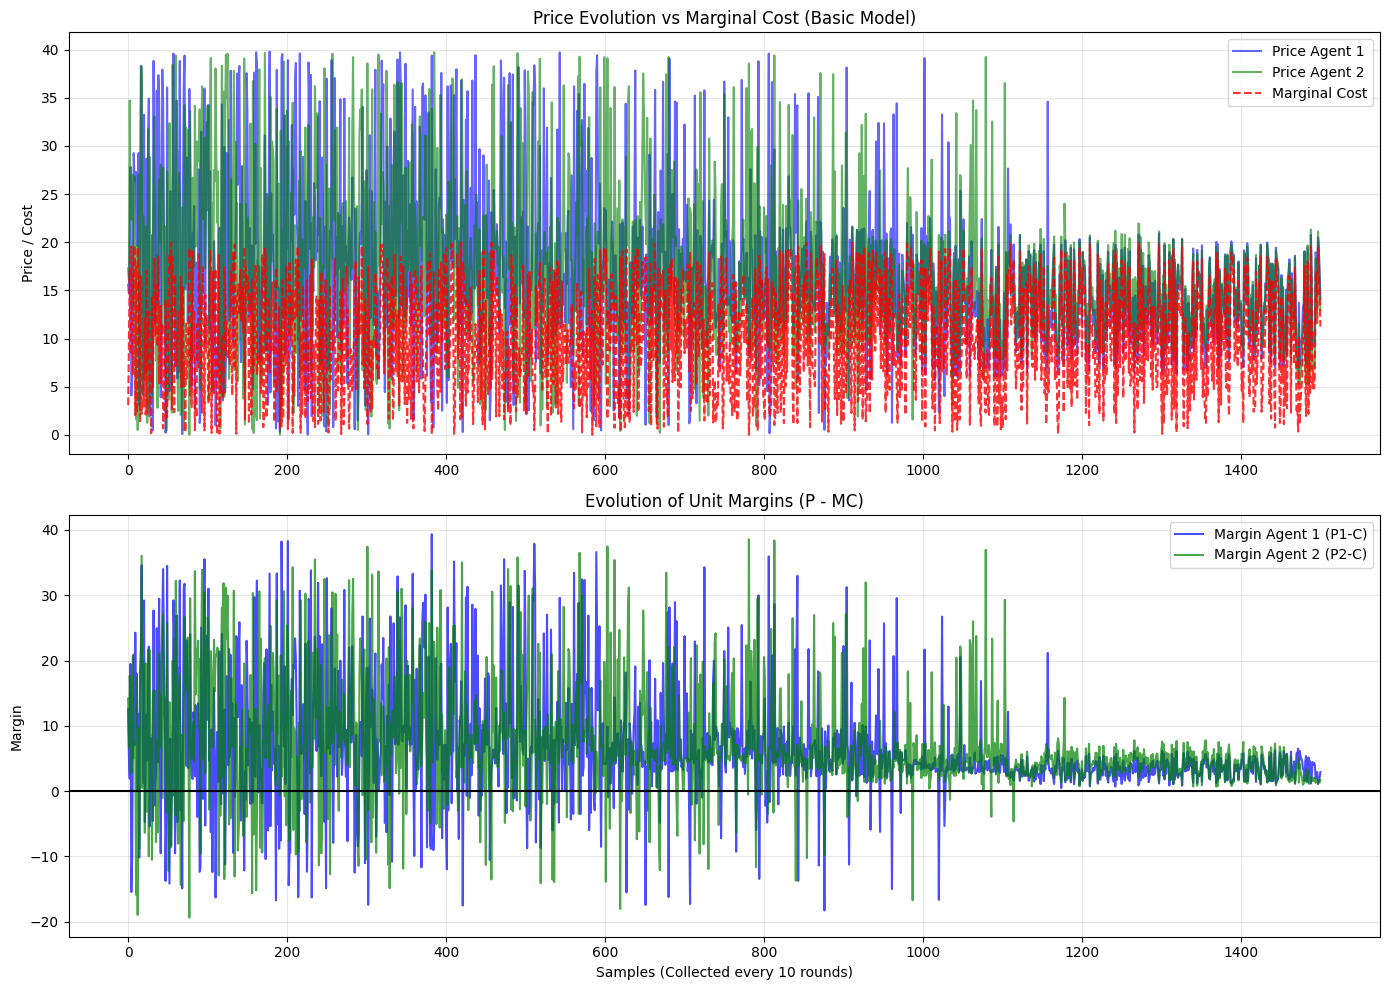

In [ ]:
import numpy as np
import functools
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
from pettingzoo.utils.env import ParallelEnv
from gymnasium.spaces import Box

# --- 1. BERTRAND COMPETITION ENVIRONMENT (PettingZoo) ---
class BertrandPettingZooEnv(ParallelEnv):
    """
    Standard Bertrand Competition Environment with homogeneous goods.
    Uses the PettingZoo Parallel API to handle simultaneous pricing actions.
    """
    def __init__(self, a=40):
        super().__init__()
        self.a = a  # Maximum market demand
        self.agents = ["player_1", "player_2"]
        self.possible_agents = self.agents[:]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        # Normalized price action between 0 and 1
        return Box(low=0, high=1, shape=(1,), dtype=np.float32)

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        # Observation is the current marginal cost
        return Box(low=0, high=1, shape=(1,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        # Initial stochastic marginal cost: 10 +/- 10
        self.current_cost = 10 + random.uniform(-10, 10)
        obs = {a: np.array([self.current_cost / self.a], dtype=np.float32) for a in self.agents}
        return obs, {}

    def step(self, actions):
        # Scale normalized actions back to market price range (0 to a)
        p1 = actions["player_1"][0] * self.a
        p2 = actions["player_2"][0] * self.a

        # Determine market demand based on the lowest price
        p_min = min(p1, p2)
        total_demand = max(0, self.a - p_min)

        # Classical Bertrand Logic: Winner takes all
        if p1 < p2:
            q1, q2 = total_demand, 0
        elif p1 > p2:
            q1, q2 = 0, total_demand
        else:
            # Split demand if prices are equal
            q1, q2 = 0.5 * total_demand, 0.5 * total_demand

        # Calculate profits (Rewards)
        r1 = (p1 - self.current_cost) * q1
        r2 = (p2 - self.current_cost) * q2

        # Generate stochastic cost for the next step (10 +/- 10)
        self.current_cost = 10 + random.uniform(-10, 10)
        next_obs = {a: np.array([self.current_cost / self.a], dtype=np.float32) for a in self.agents}
        rewards = {"player_1": float(r1), "player_2": float(r2)}

        # Standard termination flags for PettingZoo
        terminations = {a: False for a in self.agents}
        truncations = {a: False for a in self.agents}
        infos = {a: {} for a in self.agents}

        return next_obs, rewards, terminations, truncations, infos

# --- 2. DDPG AGENT ARCHITECTURE ---
class DDPGAgent(nn.Module):
    def __init__(self, lr_actor=0.0001, lr_critic=0.001):
        super().__init__()
        # Actor: Decides the price based on current cost
        self.actor = nn.Sequential(
            nn.Linear(1, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.Sigmoid()
        )
        # Critic: Evaluates the (State, Action) pair quality
        self.critic = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.memory = deque(maxlen=5000)

    def train_step(self, batch_size=128):
        if len(self.memory) < batch_size:
            return

        # Experience Replay Sampling
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)

        # Update Critic: Minimize Mean Squared Error of reward estimation
        current_q = self.critic(torch.cat([states, actions], dim=1))
        # Scaled reward for training stability
        loss_c = nn.MSELoss()(current_q, rewards / 200.0)
        self.critic_opt.zero_grad()
        loss_c.backward()
        self.critic_opt.step()

        # Update Actor: Maximize the Critic's evaluation
        loss_a = -self.critic(torch.cat([states, self.actor(states)], dim=1)).mean()
        self.actor_opt.zero_grad()
        loss_a.backward()
        self.actor_opt.step()

# --- 3. SIMULATION ENGINE ---
def run_simulation(num_rounds=15001):
    a_param = 40
    # Use the PettingZoo environment defined in Block 1
    env = BertrandPettingZooEnv(a=a_param)
    agent1, agent2 = DDPGAgent(), DDPGAgent()

    # Storage for all metrics
    history = {
        "p1": [], "p2": [], "c": [],
        "m1": [], "m2": [],
        "prof1": [], "prof2": [], "total_prof": []
    }

    print(f"{'Round':<7} | {'Cost':<6} | {'P1':<6} | {'P2':<6} | {'M1':<6} | {'M2':<6} | {'Total Prof':<10}")
    print("-" * 80)

    # Initial environment reset
    obs, _ = env.reset()

    for i in range(num_rounds):
        # Current marginal cost from the observation
        current_c = obs["player_1"][0] * a_param

        # Convert to numpy array FIRST, then to torch tensor to avoid warnings and errors
        state_p1 = torch.from_numpy(np.array([obs["player_1"]])).float()
        state_p2 = torch.from_numpy(np.array([obs["player_2"]])).float()

        # Epsilon decay for exploration strategy
        epsilon = max(0.0, 1.0 - i/12000)

        # Simultaneous Action Selection
        actions = {}
        for agent_id, state_tensor, agent_model in [("player_1", state_p1, agent1), ("player_2", state_p2, agent2)]:
            if random.random() < epsilon:
                # Random normalized price
                actions[agent_id] = np.array([random.uniform(0, 1)], dtype=np.float32)
            else:
                with torch.no_grad():
                    # Price decided by the Actor network
                    actions[agent_id] = agent_model.actor(state_tensor).numpy().flatten()

        # Step the environment with simultaneous actions
        next_obs, rewards, _, _, _ = env.step(actions)

        # Training Step
        r1, r2 = rewards["player_1"], rewards["player_2"]
        p1_norm, p2_norm = actions["player_1"][0], actions["player_2"][0]

        # Store experience in memory
        agent1.memory.append((state_p1, torch.tensor([[p1_norm]]), torch.tensor([[r1]])))
        agent2.memory.append((state_p2, torch.tensor([[p2_norm]]), torch.tensor([[r2]])))

        # Execute training (Experience Replay)
        agent1.train_step()
        agent2.train_step()

        # Log metrics every 10 rounds for plotting
        if i % 10 == 0:
            p1_actual, p2_actual = p1_norm * a_param, p2_norm * a_param
            history["p1"].append(p1_actual)
            history["p2"].append(p2_actual)
            history["c"].append(current_c)
            history["m1"].append(p1_actual - current_c)
            history["m2"].append(p2_actual - current_c)
            history["prof1"].append(r1)
            history["prof2"].append(r2)
            history["total_prof"].append(r1 + r2)

        # Print progress every 2500 rounds
        if i % 2500 == 0:
            p1_actual = actions["player_1"][0] * a_param
            p2_actual = actions["player_2"][0] * a_param
            print(f"{i:<7} | {current_c:<6.2f} | {p1_actual:<6.2f} | {p2_actual:<6.2f} | {p1_actual-current_c:<6.2f} | {p2_actual-current_c:<6.2f} | {r1+r2:<10.1f}")

        # Update current observation
        obs = next_obs

    return history


# --- 4. EXECUTION AND VISUALIZATION ---
hist_volatile = run_simulation()

plt.figure(figsize=(14, 10))

# Prices vs Cost Visualization
plt.subplot(2, 1, 1)
plt.plot(hist_volatile["p1"], label="Price Agent 1", color="blue", alpha=0.6)
plt.plot(hist_volatile["p2"], label="Price Agent 2", color="green", alpha=0.6)
plt.plot(hist_volatile["c"], label="Marginal Cost", linestyle="--", color="red", alpha=0.8)
plt.title("Price Evolution vs Marginal Cost (Basic Model)")
plt.ylabel("Price / Cost")
plt.legend()
plt.grid(True, alpha=0.3)

# Unit Margins Visualization (Proof of Bertrand Paradox)
plt.subplot(2, 1, 2)
plt.plot(hist_volatile["m1"], label="Margin Agent 1 (P1-C)", color="blue", alpha=0.7)
plt.plot(hist_volatile["m2"], label="Margin Agent 2 (P2-C)", color="green", alpha=0.7)
plt.axhline(0, color='black', lw=1.5, linestyle='-')
plt.title("Evolution of Unit Margins (P - MC)")
plt.ylabel("Margin")
plt.xlabel("Samples (Collected every 10 rounds)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This simulation replicates the classical Bertrand environment but with **low marginal cost volatility**, allowing agents to face a more stable economic environment. With reduced cost noise, prices track marginal cost more closely and converge faster, while unit margins fluctuate narrowly around zero. This highlights that price instability in earlier simulations is driven by cost uncertainty rather than sustained strategic markups, reinforcing the Bertrand competitive outcome.

Round   | Cost   | P1     | P2     | M1     | M2     | Total Prof
--------------------------------------------------------------------------------
0       | 10.33  | 0.09   | 27.12  | -10.24 | 16.79  | -408.7    
2500    | 10.21  | 19.40  | 26.12  | 9.19   | 15.91  | 189.4     
5000    | 9.47   | 16.18  | 17.60  | 6.71   | 8.13   | 159.7     
7500    | 10.40  | 37.72  | 15.53  | 27.32  | 5.13   | 125.5     
10000   | 10.30  | 14.04  | 15.10  | 3.74   | 4.80   | 97.0      
12500   | 10.38  | 14.29  | 12.96  | 3.91   | 2.58   | 69.8      
15000   | 9.95   | 14.05  | 13.32  | 4.10   | 3.37   | 89.9      


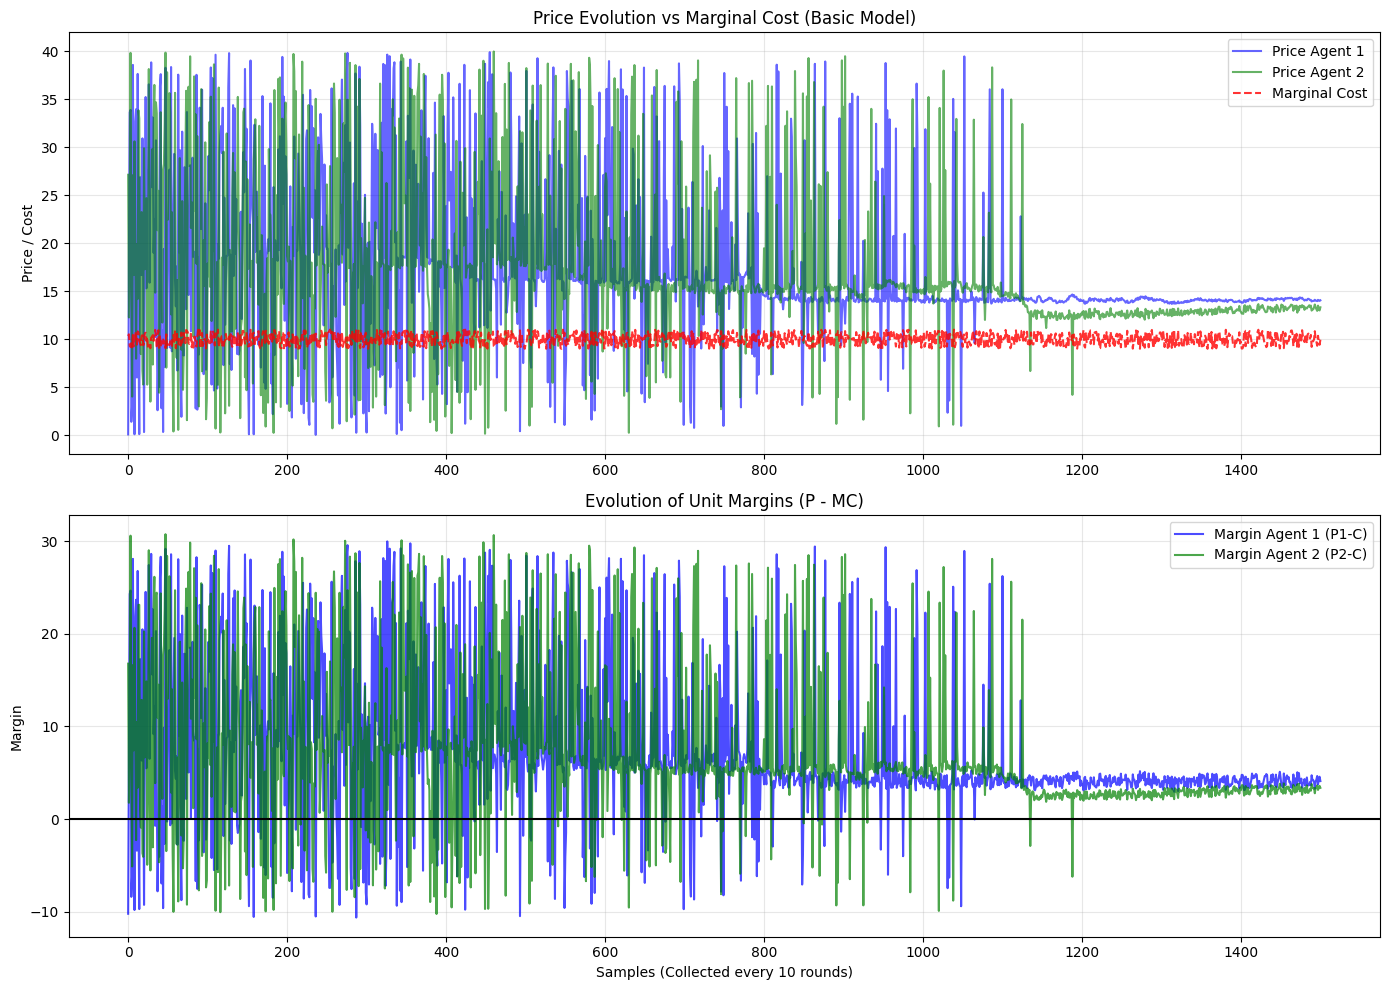

In [ ]:
import numpy as np
import functools
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
from pettingzoo.utils.env import ParallelEnv
from gymnasium.spaces import Box

# --- 1. BERTRAND COMPETITION ENVIRONMENT (PettingZoo) ---
class BertrandPettingZooEnv(ParallelEnv):
    """
    Standard Bertrand Competition Environment with homogeneous goods.
    Uses the PettingZoo Parallel API to handle simultaneous pricing actions.
    """
    def __init__(self, a=40):
        super().__init__()
        self.a = a  # Maximum market demand
        self.agents = ["player_1", "player_2"]
        self.possible_agents = self.agents[:]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        # Normalized price action between 0 and 1
        return Box(low=0, high=1, shape=(1,), dtype=np.float32)

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        # Observation is the current marginal cost
        return Box(low=0, high=1, shape=(1,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        # Initial stochastic marginal cost: 10 +/- 1
        self.current_cost = 10 + random.uniform(-1, 1)
        obs = {a: np.array([self.current_cost / self.a], dtype=np.float32) for a in self.agents}
        return obs, {}

    def step(self, actions):
        # Scale normalized actions back to market price range (0 to a)
        p1 = actions["player_1"][0] * self.a
        p2 = actions["player_2"][0] * self.a

        # Determine market demand based on the lowest price
        p_min = min(p1, p2)
        total_demand = max(0, self.a - p_min)

        # Classical Bertrand Logic: Winner takes all
        if p1 < p2:
            q1, q2 = total_demand, 0
        elif p1 > p2:
            q1, q2 = 0, total_demand
        else:
            # Split demand if prices are equal
            q1, q2 = 0.5 * total_demand, 0.5 * total_demand

        # Calculate profits (Rewards)
        r1 = (p1 - self.current_cost) * q1
        r2 = (p2 - self.current_cost) * q2

        # Generate stochastic cost for the next step (10 +/- 1)
        self.current_cost = 10 + random.uniform(-1, 1)
        next_obs = {a: np.array([self.current_cost / self.a], dtype=np.float32) for a in self.agents}
        rewards = {"player_1": float(r1), "player_2": float(r2)}

        # Standard termination flags for PettingZoo
        terminations = {a: False for a in self.agents}
        truncations = {a: False for a in self.agents}
        infos = {a: {} for a in self.agents}

        return next_obs, rewards, terminations, truncations, infos

# --- 2. DDPG AGENT ARCHITECTURE ---
class DDPGAgent(nn.Module):
    def __init__(self, lr_actor=0.0001, lr_critic=0.001):
        super().__init__()
        # Actor: Decides the price based on current cost
        self.actor = nn.Sequential(
            nn.Linear(1, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.Sigmoid()
        )
        # Critic: Evaluates the (State, Action) pair quality
        self.critic = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.memory = deque(maxlen=5000)

    def train_step(self, batch_size=128):
        if len(self.memory) < batch_size:
            return

        # Experience Replay Sampling
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)

        # Update Critic: Minimize Mean Squared Error of reward estimation
        current_q = self.critic(torch.cat([states, actions], dim=1))
        # Scaled reward for training stability
        loss_c = nn.MSELoss()(current_q, rewards / 200.0)
        self.critic_opt.zero_grad()
        loss_c.backward()
        self.critic_opt.step()

        # Update Actor: Maximize the Critic's evaluation
        loss_a = -self.critic(torch.cat([states, self.actor(states)], dim=1)).mean()
        self.actor_opt.zero_grad()
        loss_a.backward()
        self.actor_opt.step()

# --- 3. SIMULATION ENGINE ---
def run_simulation(num_rounds=15001):
    a_param = 40
    # Use the PettingZoo environment defined in Block 1
    env = BertrandPettingZooEnv(a=a_param)
    agent1, agent2 = DDPGAgent(), DDPGAgent()

    # Storage for all metrics (English naming)
    history = {
        "p1": [], "p2": [], "c": [],
        "m1": [], "m2": [],
        "prof1": [], "prof2": [], "total_prof": []
    }

    print(f"{'Round':<7} | {'Cost':<6} | {'P1':<6} | {'P2':<6} | {'M1':<6} | {'M2':<6} | {'Total Prof':<10}")
    print("-" * 80)

    # Initial environment reset
    obs, _ = env.reset()

    for i in range(num_rounds):
        # Current marginal cost from the observation
        current_c = obs["player_1"][0] * a_param

        # Convert to numpy array FIRST, then to torch tensor to avoid warnings and errors
        state_p1 = torch.from_numpy(np.array([obs["player_1"]])).float()
        state_p2 = torch.from_numpy(np.array([obs["player_2"]])).float()

        # Epsilon decay for exploration strategy
        epsilon = max(0.0, 1.0 - i/12000)

        # Simultaneous Action Selection
        actions = {}
        for agent_id, state_tensor, agent_model in [("player_1", state_p1, agent1), ("player_2", state_p2, agent2)]:
            if random.random() < epsilon:
                # Random normalized price
                actions[agent_id] = np.array([random.uniform(0, 1)], dtype=np.float32)
            else:
                with torch.no_grad():
                    # Price decided by the Actor network
                    actions[agent_id] = agent_model.actor(state_tensor).numpy().flatten()

        # Step the environment with simultaneous actions
        next_obs, rewards, _, _, _ = env.step(actions)

        # Training Step
        r1, r2 = rewards["player_1"], rewards["player_2"]
        p1_norm, p2_norm = actions["player_1"][0], actions["player_2"][0]

        # Store experience in memory
        agent1.memory.append((state_p1, torch.tensor([[p1_norm]]), torch.tensor([[r1]])))
        agent2.memory.append((state_p2, torch.tensor([[p2_norm]]), torch.tensor([[r2]])))

        # Execute training (Experience Replay)
        agent1.train_step()
        agent2.train_step()

        # Log metrics every 10 rounds for plotting
        if i % 10 == 0:
            p1_actual, p2_actual = p1_norm * a_param, p2_norm * a_param
            history["p1"].append(p1_actual)
            history["p2"].append(p2_actual)
            history["c"].append(current_c)
            history["m1"].append(p1_actual - current_c)
            history["m2"].append(p2_actual - current_c)
            history["prof1"].append(r1)
            history["prof2"].append(r2)
            history["total_prof"].append(r1 + r2)

        # Print progress every 2500 rounds
        if i % 2500 == 0:
            p1_actual = actions["player_1"][0] * a_param
            p2_actual = actions["player_2"][0] * a_param
            print(f"{i:<7} | {current_c:<6.2f} | {p1_actual:<6.2f} | {p2_actual:<6.2f} | {p1_actual-current_c:<6.2f} | {p2_actual-current_c:<6.2f} | {r1+r2:<10.1f}")

        # Update current observation
        obs = next_obs

    return history


# --- 4. EXECUTION AND VISUALIZATION ---
hist_stable = run_simulation()

plt.figure(figsize=(14, 10))

# Prices vs Cost Visualization
plt.subplot(2, 1, 1)
plt.plot(hist_stable["p1"], label="Price Agent 1", color="blue", alpha=0.6)
plt.plot(hist_stable["p2"], label="Price Agent 2", color="green", alpha=0.6)
plt.plot(hist_stable["c"], label="Marginal Cost", linestyle="--", color="red", alpha=0.8)
plt.title("Price Evolution vs Marginal Cost (Basic Model)")
plt.ylabel("Price / Cost")
plt.legend()
plt.grid(True, alpha=0.3)

# Unit Margins Visualization (Proof of Bertrand Paradox)
plt.subplot(2, 1, 2)
plt.plot(hist_stable["m1"], label="Margin Agent 1 (P1-C)", color="blue", alpha=0.7)
plt.plot(hist_stable["m2"], label="Margin Agent 2 (P2-C)", color="green", alpha=0.7)
plt.axhline(0, color='black', lw=1.5, linestyle='-')
plt.title("Evolution of Unit Margins (P - MC)")
plt.ylabel("Margin")
plt.xlabel("Samples (Collected every 10 rounds)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This  code compares margin dynamics under high and low marginal cost volatility. In the volatile-cost environment, margins exhibit larger and more persistent fluctuations, reflecting greater uncertainty during learning. In contrast, with stable costs, margins converge more tightly around zero, indicating faster learning and reinforcing the Bertrand prediction that cost stability accelerates convergence to competitive pricing.



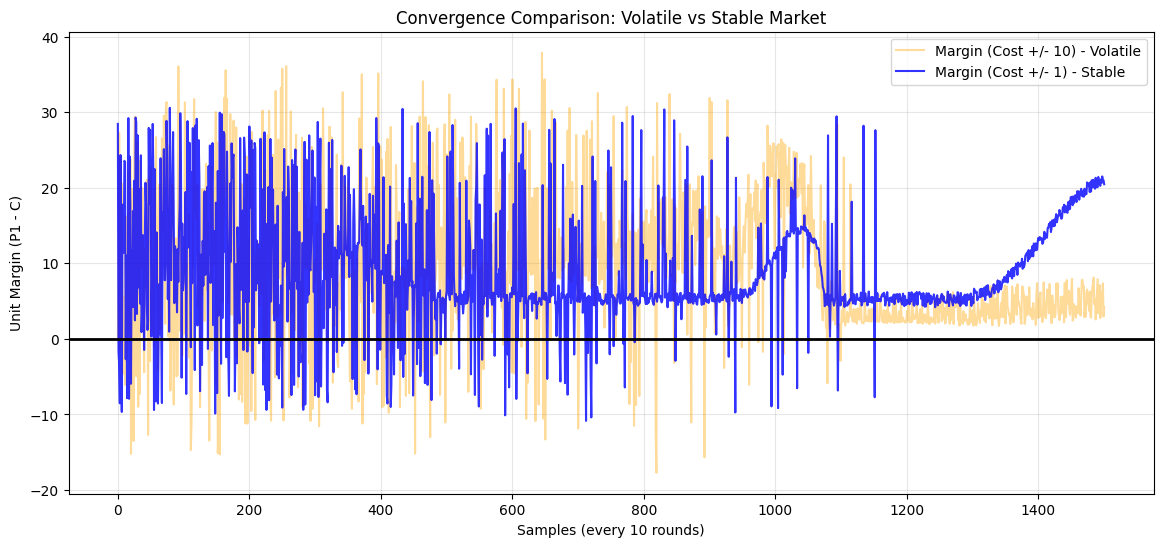

In [ ]:
plt.figure(figsize=(14, 6))

# Margins Comparisons
plt.plot(hist_volatile["m1"], label="Margin (Cost +/- 10) - Volatile", alpha=0.4, color='orange')
plt.plot(hist_stable["m1"], label="Margin (Cost +/- 1) - Stable", alpha=0.8, color='blue')

plt.axhline(0, color='black', lw=2)
plt.title("Convergence Comparison: Volatile vs Stable Market")
plt.xlabel("Samples (every 10 rounds)")
plt.ylabel("Unit Margin (P1 - C)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## **Model Extension** ##

Two‑agent Bertrand pricing environment using the PettingZoo AEC API. Each firm chooses a price for a homogeneous good in a simultaneous‑move game. Observations include only market parameters (A, B, c), so rival prices are not observed.
Demand is linear and market shares follow a logit rule, providing a smooth version of the classical Lowest‑price‑win mechanism. The episode ends once both firms set prices, making the game one‑shot.

In [ ]:
!pip install pettingzoo

import numpy as np
from gymnasium import spaces
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers

class BertrandPettingZooEnv(AECEnv):
    metadata = {"render_modes": [], "name": "bertrand_v0"}

    def __init__(self, A=10.0, B=1.0, c=2.0, p_max=20.0,
                 A_noise=1.0, tau=0.2, seed=0):
        super().__init__()
        self.rng = np.random.default_rng(seed)

        self.A0, self.B, self.c = float(A), float(B), float(c)
        self.p_max = float(p_max)
        self.A_noise = float(A_noise)
        self.tau = float(tau)


        self.possible_agents = ["firm_1", "firm_2"]
        self.agents = self.possible_agents[:]


        self._action_spaces = {
            agent: spaces.Box(
                low=np.array([self.c], dtype=np.float32),
                high=np.array([self.p_max], dtype=np.float32),
                dtype=np.float32
            )
            for agent in self.possible_agents
        }

        # SIMULTANEOUS Observation: [A, B, c] without rival's price
        self._observation_spaces = {
            agent: spaces.Box(
                low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32
            )
            for agent in self.possible_agents
        }

        self.A = self.A0
        self.prices = {agent: self.c for agent in self.possible_agents}
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = None

    def observation_space(self, agent):
        return self._observation_spaces[agent]

    def action_space(self, agent):
        return self._action_spaces[agent]

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.agents = self.possible_agents[:]
        self.A = float(max(0.0, self.A0 + self.rng.normal(0.0, self.A_noise)))
        self.prices = {agent: self.c for agent in self.possible_agents}

        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}

        self._agent_selector.reinit(self.agents)
        self.agent_selection = self._agent_selector.next()

    def observe(self, agent):

        return np.array([self.A, self.B, self.c], dtype=np.float32)

    def step(self, action):
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            return self._was_dead_step(action)

        agent = self.agent_selection


        price = float(np.clip(action[0], self.c, self.p_max))
        self.prices[agent] = price


        if agent == "firm_2":
            p1 = self.prices["firm_1"]
            p2 = self.prices["firm_2"]

            D1 = max(0.0, self.A - self.B * p1)
            D2 = max(0.0, self.A - self.B * p2)

            s1 = 1.0 / (1.0 + np.exp((p1 - p2) / self.tau))
            s2 = 1.0 - s1

            q1 = D1 * s1
            q2 = D2 * s2

            profit1 = (p1 - self.c) * q1
            profit2 = (p2 - self.c) * q2

            self._cumulative_rewards["firm_1"] = float(profit1)
            self._cumulative_rewards["firm_2"] = float(profit2)

            self.infos["firm_1"] = {"price": p1, "quantity": q1, "profit": profit1}
            self.infos["firm_2"] = {"price": p2, "quantity": q2, "profit": profit2}


            self.terminations = {agent: True for agent in self.agents}


        self.agent_selection = self._agent_selector.next()

        self._accumulate_rewards()

    def _was_dead_step(self, action):
        self.agent_selection = self._agent_selector.next()
        self._accumulate_rewards()



def env(**kwargs):
    env = BertrandPettingZooEnv(**kwargs)
    env = wrappers.AssertOutOfBoundsWrapper(env)
    env = wrappers.OrderEnforcingWrapper(env)
    return env

Single‑agent wrapper and self‑play training loop for a two‑firm Bertrand pricing game. Each agent observes only market fundamentals (A, B, c) and sets a price in a one‑shot, simultaneous‑move environment. The wrapper allows SB3 to treat the opponent as part of the environment by querying its policy during each step. Self‑play alternates training between both agents, updating each one against the current version of its rival.


In [ ]:
!pip install stable-baselines3

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
import gymnasium as gym

# Wrapper for SB3: simultaneous game
class SingleAgentWrapper(gym.Env):
    def __init__(self, A=10.0, B=1.0, c=2.0, p_max=20.0, tau=0.2, seed=0):
        super().__init__()
        self.A0 = A
        self.B = B
        self.c = c
        self.p_max = p_max
        self.tau = tau
        self.A_noise = 1.0
        self.rng = np.random.default_rng(seed)

        self.action_space = spaces.Box(
            low=np.array([c], dtype=np.float32),
            high=np.array([p_max], dtype=np.float32),
            dtype=np.float32
        )

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32
        )

        self.opponent_policy = None
        self.A = self.A0

    def set_opponent(self, opponent_policy):
        self.opponent_policy = opponent_policy

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.A = float(max(0.0, self.A0 + self.rng.normal(0.0, self.A_noise)))
        obs = np.array([self.A, self.B, self.c], dtype=np.float32)

        return obs, {}

    def step(self, action):
        # Agent 1 plays
        p1 = float(np.clip(action[0], self.c, self.p_max))

        # Agent 2 plays (with the same observation - SIMULTANEOUS game)
        obs = np.array([self.A, self.B, self.c], dtype=np.float32)

        if self.opponent_policy is None:
            p2 = self.c
        else:
            a2, _ = self.opponent_policy.predict(obs, deterministic=True)
            p2 = float(np.clip(a2[0], self.c, self.p_max))


        D1 = max(0.0, self.A - self.B * p1)

        s1 = 1.0 / (1.0 + np.exp((p1 - p2) / self.tau))
        q1 = D1 * s1

        profit = (p1 - self.c) * q1


        next_obs = np.array([self.A, self.B, self.c], dtype=np.float32)

        info = {"p1": p1, "p2": p2, "q1": q1, "profit": profit}

        terminated = True  # One-shot game
        truncated = False

        return next_obs, float(profit), terminated, truncated, info


def make_ddpg(env, seed=0):
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.15 * np.ones(n_actions)
    )

    return DDPG(
        "MlpPolicy",
        env,
        learning_rate=1e-3,
        buffer_size=50_000,
        batch_size=128,
        tau=0.2,
        gamma=0.0,
        action_noise=action_noise,
        train_freq=(1, "step"),
        gradient_steps=1,
        policy_kwargs=dict(net_arch=[64, 64]),
        verbose=0,
        seed=seed
    )


def train_self_play(rounds=10, steps_per_round=10_000):
    A, B, c, p_max = 10.0, 1.0, 2.0, 20.0

    env1 = SingleAgentWrapper(A=A, B=B, c=c, p_max=p_max, tau=0.2, seed=0)
    env2 = SingleAgentWrapper(A=A, B=B, c=c, p_max=p_max, tau=0.2, seed=1)

    agent1 = make_ddpg(env1, seed=0)
    agent2 = make_ddpg(env2, seed=1)

    history = {"p1": [], "p2": [], "pi1": [], "pi2": []}

    for k in range(rounds):
        env1.set_opponent(agent2)
        agent1.set_env(env1)
        agent1.learn(total_timesteps=steps_per_round, reset_num_timesteps=False)

        env2.set_opponent(agent1)
        agent2.set_env(env2)
        agent2.learn(total_timesteps=steps_per_round, reset_num_timesteps=False)

        mp1, mp2, mpi1, mpi2 = eval_pair(agent1, agent2, tau=0.2)
        history["p1"].append(mp1)
        history["p2"].append(mp2)
        history["pi1"].append(mpi1)
        history["pi2"].append(mpi2)

        print(
            f"[round {k+1}] "
            f"mean p1={mp1:.4f}, p2={mp2:.4f} | "
            f"mean pi1={mpi1:.6f}, pi2={mpi2:.6f}"
        )

    return agent1, agent2, history


def eval_pair(agent1, agent2, A=10.0, B=1.0, c=2.0, p_max=20.0, n=500, seed=123, tau=0.2):
    rng = np.random.default_rng(seed)
    p1s, p2s, pi1s, pi2s = [], [], [], []

    for _ in range(n):
        A_t = float(max(0.0, A + rng.normal(0.0, 1.0)))


        obs = np.array([A_t, B, c], dtype=np.float32)

        a1, _ = agent1.predict(obs, deterministic=True)
        p1 = float(np.clip(a1[0], c, p_max))

        a2, _ = agent2.predict(obs, deterministic=True)
        p2 = float(np.clip(a2[0], c, p_max))

        D1 = max(0.0, A_t - B * p1)
        D2 = max(0.0, A_t - B * p2)

        s1 = 1.0 / (1.0 + np.exp((p1 - p2) / tau))
        s2 = 1.0 - s1

        q1 = D1 * s1
        q2 = D2 * s2

        pi1 = (p1 - c) * q1
        pi2 = (p2 - c) * q2

        p1s.append(p1); p2s.append(p2)
        pi1s.append(pi1); pi2s.append(pi2)

    return np.mean(p1s), np.mean(p2s), np.mean(pi1s), np.mean(pi2s)


if __name__ == "__main__":
    pass

Visualization of self‑play results. The plots show how average prices and profits evolve across training rounds for both agents. Price dynamics are compared against the marginal cost benchmark, illustrating convergence toward the Bertrand outcome. Profit trajectories reflect the erosion of margins as competition intensifies.

In [ ]:
    !pip install pettingzoo stable-baselines3

[round 1] mean p1=5.6310, p2=4.9822 | mean pi1=0.588214, pi2=14.660016
[round 2] mean p1=3.9923, p2=3.4860 | mean pi1=0.876957, pi2=9.108465
[round 3] mean p1=7.1787, p2=3.7114 | mean pi1=0.000001, pi2=10.893130
[round 4] mean p1=3.1710, p2=4.9523 | mean pi1=8.046030, pi2=0.020107
[round 5] mean p1=3.4098, p2=3.1388 | mean pi1=1.865900, pi2=6.320571
[round 6] mean p1=3.2105, p2=3.0621 | mean pi1=2.611583, pi2=5.111099
[round 7] mean p1=3.0272, p2=2.9774 | mean pi1=3.114170, pi2=3.930723
[round 8] mean p1=2.9417, p2=2.8969 | mean pi1=2.973102, pi2=3.571362
[round 9] mean p1=2.7660, p2=2.8664 | mean pi1=3.466815, pi2=2.352825
[round 10] mean p1=2.7554, p2=2.8066 | mean pi1=3.063446, pi2=2.586379


/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:85: DeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:89: DeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2010: DeprecationWarning: 'oneOf' deprecated - use 'one_of'
  p.space          = oneOf(self._space_widths)("space")
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2020: DeprecationWarning: 'leaveWhitespace' deprecated - use 'leave_whitespace'
  )("sym").leaveWhitespace()
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:1984: DeprecationWarning: 'setName' deprecated - use 'set_name'
  val.setName(key)
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:1987: DeprecationWarning: 'setParseAction' deprecated - use 'set_parse_action'
  val.setPa

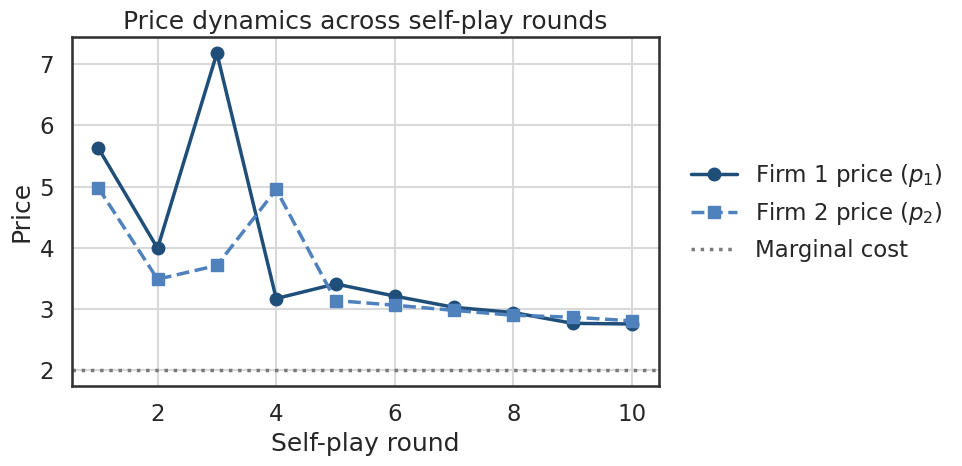

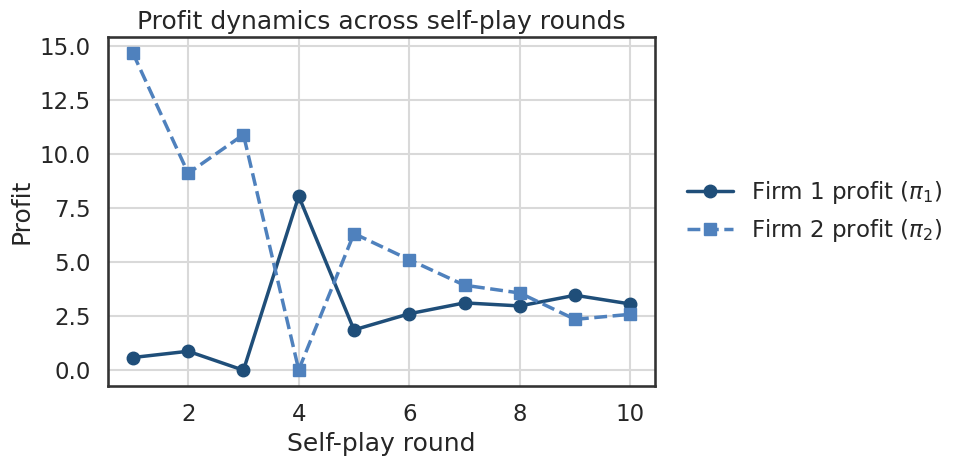

In [ ]:

    agent1, agent2, history = train_self_play()


    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(
        style="whitegrid",
        context="talk",
        rc={"axes.edgecolor": "0.2", "grid.color": "0.85"}
    )

    rounds = range(1, len(history["p1"]) + 1)
    blue_dark = "#1f4e79"
    blue_light = "#4f81bd"
    cost_color = "#7a7a7a"

    # Prices
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(rounds, history["p1"], marker="o", linewidth=2.5,
            color=blue_dark, label=r"Firm 1 price ($p_1$)")
    ax.plot(rounds, history["p2"], marker="s", linewidth=2.5,
            linestyle="--", color=blue_light, label=r"Firm 2 price ($p_2$)")
    ax.axhline(y=2.0, linestyle=":", linewidth=2.5,
               color=cost_color, label="Marginal cost")
    ax.set_xlabel("Self-play round")
    ax.set_ylabel("Price")
    ax.set_title("Price dynamics across self-play rounds")
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.tight_layout()
    plt.show()

    # Profits
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(rounds, history["pi1"], marker="o", linewidth=2.5,
            color=blue_dark, label=r"Firm 1 profit ($\pi_1$)")
    ax.plot(rounds, history["pi2"], marker="s", linewidth=2.5,
            linestyle="--", color=blue_light, label=r"Firm 2 profit ($\pi_2$)")
    ax.set_xlabel("Self-play round")
    ax.set_ylabel("Profit")
    ax.set_title("Profit dynamics across self-play rounds")
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.tight_layout()
    plt.show()